# ECE 311 Lab 2: LSI Systems

In this lab, we will explore Linear Shift-Invariant (LSI) systems and their properties with applications involving toy signals, image filtering, stock data, and even an example of a simple non-linear system. Let's get started!

In [1]:
#import necessary libraries for this lab
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

from skimage.io import imread

%matplotlib inline

## Getting Started with Convolution

We remember from ECE 210, that convolution describes how any continuous-time input signal is processed by an LTI system. Given an input $x(t)$ and an LTI system's impulse response $h(t)$, the system output $y(t)$ is given by

$$
y(t) = x(t) * h(t).
$$

Recall that convolution for continous signals is defined as

$$
y(t) = \int_{\tau = -\infty}^{\infty}x(\tau)h(t-\tau)d\tau = \int_{\tau=-\infty}^{\infty}x(t-\tau)h(\tau)d\tau.
$$

You have learned in ECE 310 that discrete-time LSI systems also have an impulse response $h[n]$, which is the system response to a unit Kronecker delta $\delta[n]$ input. Thus we can express the system output given an input signal via discrete-time convolution.

$$
y[n] = x[n] * h[n]
$$

$$
y[n] = \sum_{k=-\infty}^{\infty}x[k]h[n-k] = \sum_{k=-\infty}^{\infty}x[n-k]h[k]
$$

Like the width properties of continuous-time convolution, if $x$ is of length $N$ and $h$ is of length $M$, the result $y$ will be of length $N+M-1$. It is important to note that every LSI system can be represented by a convolution, every system that can be expressed as a convolution has an impulse response, and any system with an impulse response must be LSI. This means the relationship between LSI systems, convolution, and impulse responses is an "if and only if" relationship; they all imply one another! This is something handy to keep in mind whenever you want to identify and describe an LSI system.

The key function we will use to perform convolutions is the $\textrm{convolve()}$ function in the $\textrm{scipy.signal}$ module. The usage of this function for an example system is as follows:

$$
x[n] = \delta[n]+2\delta[n-2]+3\delta[n-4]
$$

$$
y[n] = x[n]+3x[n-1]
$$

In [2]:
x = np.array([1, 0, 2, 0, 3]) #input signal
h = np.array([1, 3]) #filter/system's impulse response
y = signal.convolve(x,h) #signal.convolve(in1,in2)

print(y) #verify this result by hand!

[1 3 2 6 3 9]


Note how we extracted the system's impulse response for the system's Linear Constant Coefficient Difference Equation (LCCDE). Our first term takes the present input value and multiplies it by one, and the second term multiplies the most recent input by three. Intuitively, when we flip and shift our filter $h$ for the convolution, we will be applying this system to the input signal at each shift step. The $\textrm{signal.convolve()}$ function assumes the arrays that represent our signals begin at index zero.

## Exercise 1: Implementing LSI Systems

In the below code cell, implement the following LSI systems and plot the system response (using $\textrm{plt.stem()}$) to each of the listed input signals. Comment on the results in the following Markdown cell. Remember to determine the LCCDE for each system to infer its impulse response!

* System A: $y_a[n] = -x[n]+2x[n-1]-x[n-2]$


* System B: $y_b[n] = \frac{1}{4}x[n]+\frac{1}{2}x[n-1]+\frac{1}{4}x[n-2]$



* $x_1[n] = u[n] - u[n-7], 0\leq n< 10$


* $x_2[n] = \sin\left(\frac{\pi}{20}n\right), 0\leq n< 40$

Text(0, 0.5, '$y_{b,2}$')

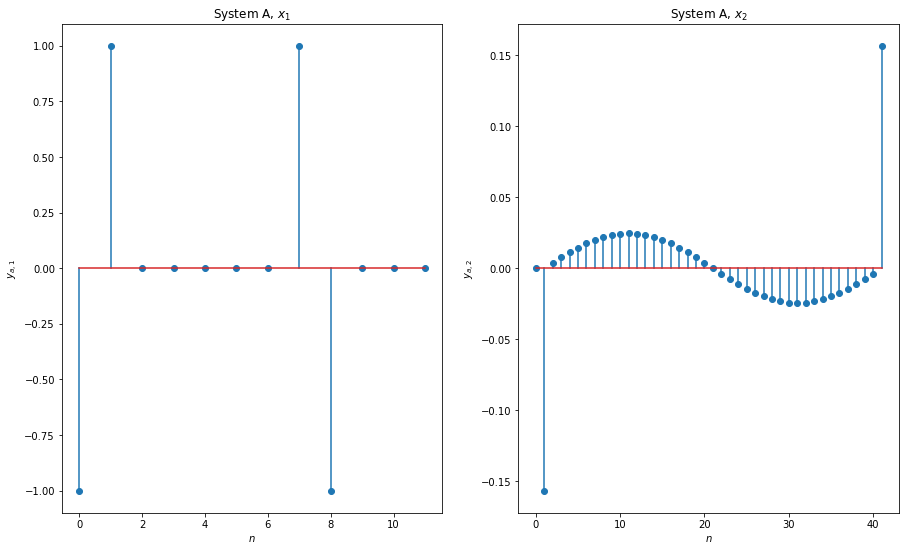

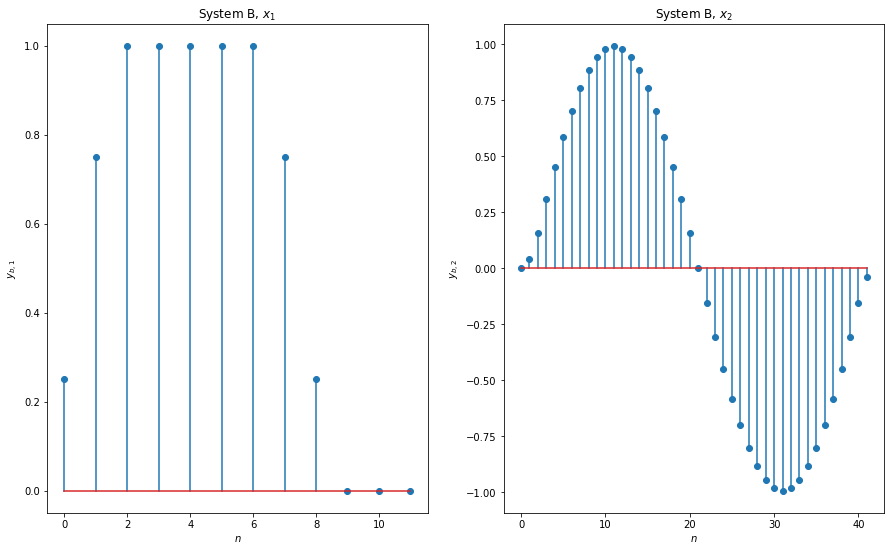

Comments here:
(Consider how the different filters affect the flatter and faster moving parts of the input signals. What do you think each filter is doing?)

The first filter seems to encourage changes in the signal, while the second filter smooths out the input signal. We see the first filter sets the first input to zero everyone except at its edges. Conversely, the second filter just rounds out these edges.

## Exercise 2: Bitcoin Pricing Correction

One type of signal could be some non-physical 1D information. An example of this would be stock price or cryptocurrency data. This data is notoriously noisy and can jump around unpredictably.

Remember that the systems we work with can be either causal or non-causal. A causal system only uses present and past information or values to calculate its present values, while a non-causal system can leverage future information. In this excercise, we will compare causal and non-causal versions of a filter to smooth a day's worth of bitcoin pricing data. We have provided 24 hours of prices with pricing updates every minute (1440 points). The date in question is Christmas Eve Day (12/24), 2017.

Text(0, 0.5, 'Price (USD)')

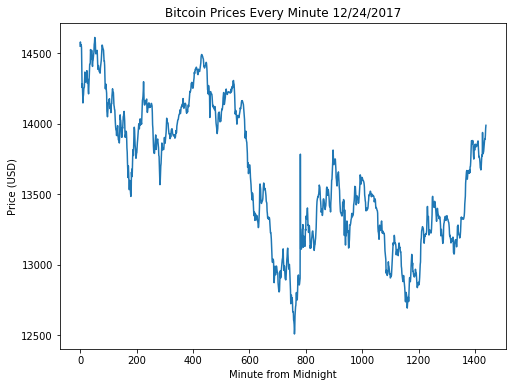

In [4]:
bitcoin_data = np.load('bitcoin-christmas.npy', allow_pickle=True)
n_points = len(bitcoin_data)
plt.figure(figsize = (8,6))
plt.plot(range(n_points), bitcoin_data)
plt.title('Bitcoin Prices Every Minute 12/24/2017')
plt.xlabel('Minute from Midnight')
plt.ylabel('Price (USD)')

Pretty noisy, right? Maybe a lot of last-minute Christmas gifts made the price even more unpredictable!

In this exercise, you will implement two length-51 moving average filters on this Bitcoin price data. The first will be causal and the second will be non-causal. Mathematically, we can represent these systems as follows:

$$
y_1[n] = \frac{1}{51}\sum_{i=0}^{50}x[n - i]
$$

$$
y_2[n] = \frac{1}{51}\sum_{i=-25}^{25}x[n - i]
$$

Furthermore, since the moving average filter is an LSI system we may implement it as a convolution. If you are having trouble seeing this, we suggest considering a length-5 moving average filter and "unrolling" the sum for that system definition.

Notice that the non-causal filter will require us to access negative indices according to the impulse response of our filter. A natural question to ask is how does the $\textrm{signal.convolve()}$ function perform non-causal convolution? How can you indicate negative indices when making an array for a system's impulse response? This is where the "same" mode comes in! We may use the "same" mode as follows:

```
y = signal.convolve(x,h,'same'),
```

where $x$ is of length $N$ and $h$ is length $M$. This line of code will perform a full linear convolution like the default mode, but then it will only keep the center $N$ values (length of first argument/array). This operation is equivalent to zero-centering our filter array (second argument/array). You may want to try a couple small examples to convince yourself this is true. The "same" mode will be important to keep in mind throughout this lab and the rest of the course.

**Important Note:** For the following two parts, we have provided the appropriate start and end indices to help us make sure each implementation returns results of the same size and to remove initial condition worries (ramping behavior since we would have fewer than 51 samples as the filter has partial overlap).

a. Construct the causal filter and apply it to the provided bitcoin price data (contained in the ``bitcoin_data`` variable). To make sure your output is the same length and matches up correctly in time, you should slice your result using ``start`` and ``end`` as we did to create the ``plotting_data`` variable. Plot the original data (``plotting_data``) and your smoothed data on the same plot.

b. Construct the non-causal filter and apply it to the provided bitcoin price data. Perform the same ``start`` and ``end`` slicing on your result as in part (a). Plot the original data (``plotting_data``) and your smoothed data on the same plot.

c. Plot the error signals for each filter on the same plot. Let the error signal for a system's output be given by

$$
y_e = y - \hat{y},
$$

where $\hat{y}$ is your system output and $y$ is the sliced original data used for plotting, ``plotting_data``.

d. Comment on the results in the following Markdown cell. What is noticeably different? Is it better to know a lot of past information or a decent amount of past and future information?

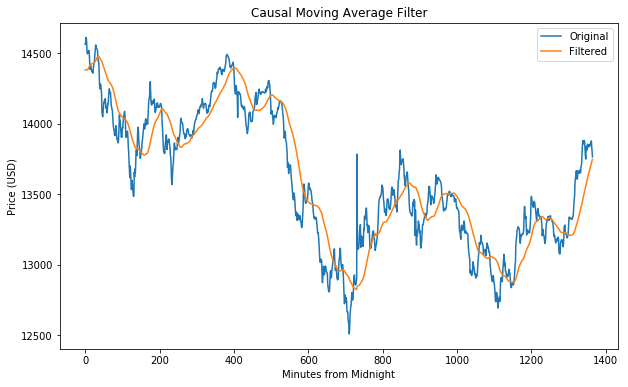

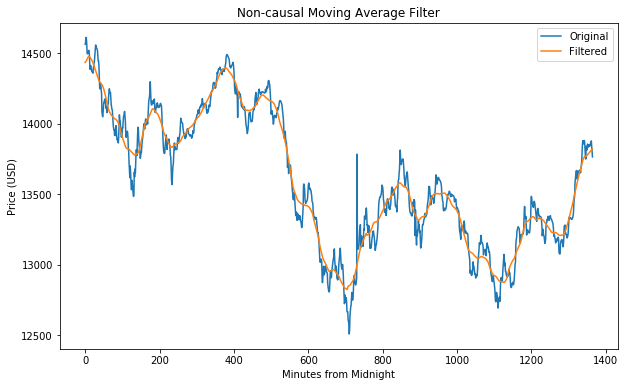

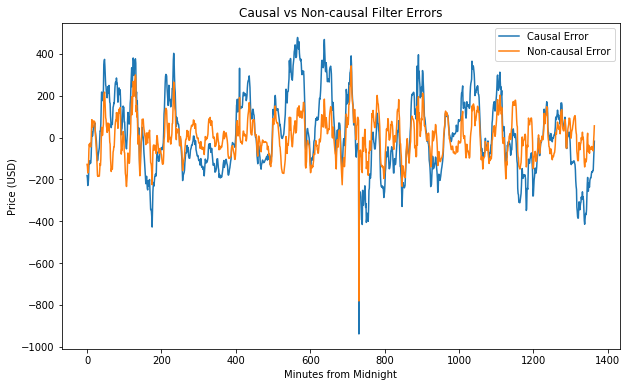

Comments for part 2.d here:

The causal filter produces shifted outputs since it is responding to more past information. This makes the filter less sensitive to recent changes. Conversely, the non-causal filter is well centered on the original data and provides a nicely smoothed version of the data. Clearly, it is helpful to know some data about the future and some data about the past.

# Image Convolution

In ECE 310, we typically focus on the implications of filtering in the frequency domain of a 1D signal. Our most common idea of a 1D signal is a piece of audio. In this section, we will experiment with image filtering along both axes of an image and see that we can do more than just filtering with convolution.

## Exercise 3: 1D Image Convolution

Apply a 1D length 11 moving average filter on the provided ``test-image.jpg`` image along its:

a. Rows

b. Columns

c. Rows then columns

d. Columns then rows

Plot each of the resulting images and give them unique titles.

e. Comment on the images from the "rows then columns" and "columns then rows" procedures. Are they the same? Explain your answer, why are they the same or different?

Text(0.5, 1.0, 'Column-row-filtered Image')

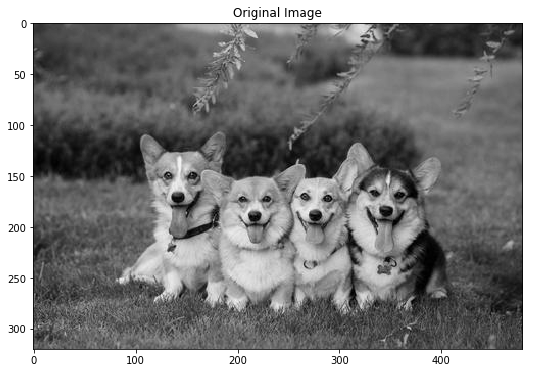

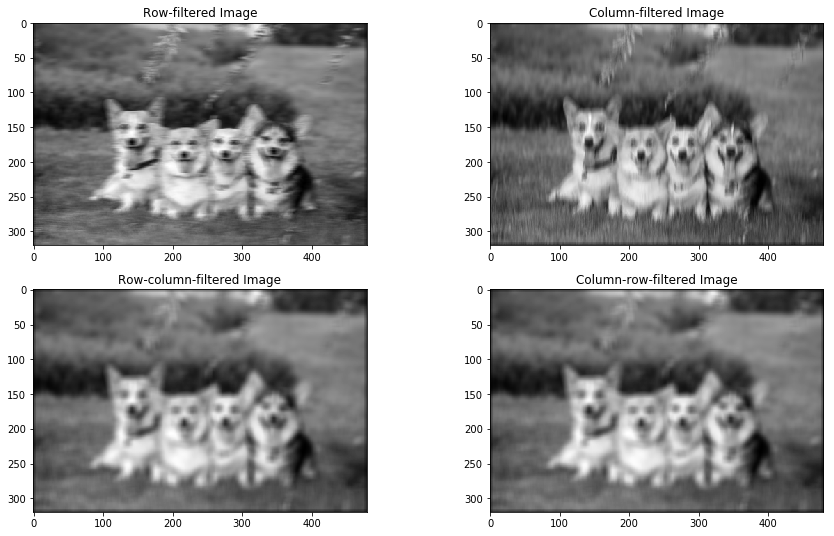

Comments for 3.e:

The row-column and column-row images are identical because the convolution operator commutes (commutativity property).

## Exercise 4: Building an Edge Detector

Let's now apply image convolution to perform edge detection. We will build a simple edge detector step-by-step using the following simple 1D filter:

$$
h[n] = \delta[n+1] - \delta[n-1]
$$

a. Intuitively or mathematically, what does this filter do to an input signal? In other words, what parts of a signal would give a strong (large magnitude) response and what parts would give a weak (small magnitude) response? You may answer this with a couple signal examples and the result of convolution with $h[n]$ or qualitative intuition.

b. Is this filter causal? Why or why not? Is it a problem if the filter is non-causal? (Hint: consider the contexts in which we cannot violate causality!)

Note: For the next two parts, please store your results in separate variables. This will make part (e) much cleaner.

c. Apply $h[n]$ along the rows of the ``test-image.jpg`` image. Plot the result with a grayscale color mapping.

d. Apply $h[n]$ along the columns of the ``test-image.jpg`` image. Plot the result with a grascale color mapping.

So far we have checked for edge-like features in the image going along the rows and columns. Imagine these two results as being vectors indicating edge strength along the row axis and column axis of the image, respectively. Take a minute to look at the differences between these two resulting images. Can you tell which one is detecting edges within a row and which one is doing so within a column? What would be a sensible way to incorporate these two dimensions of information? Imagine they form a 2D vector and take the norm! More precisely:

$$
I_F(r,c) = \sqrt{\left(I_R(r,c)\right)^2 + \left(I_C(r,c)\right)^2},
$$

where $I_R$ and $I_C$ are the row and column filtered results, respectively.

e. Build the final result image $I_F$ according to the above equation. Plot the result again with a grayscale color mapping.

Answer for 4.a here:


Answer for 4.b here:



Text(0.5, 1.0, '$I_F$')

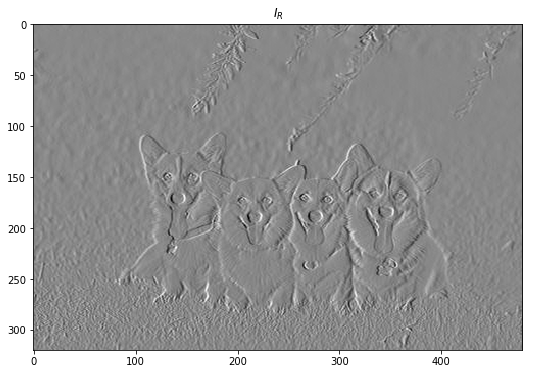

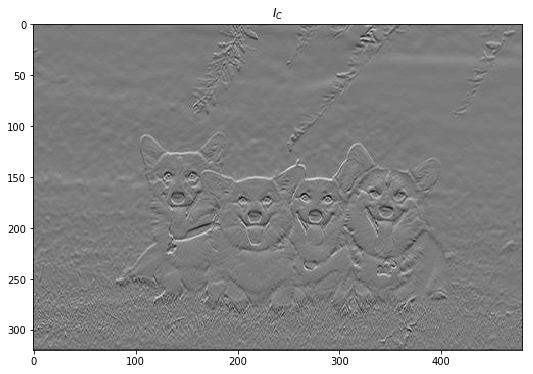

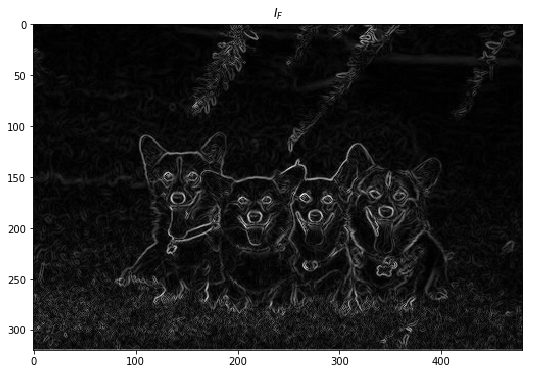

## 2D Image Convolution

We don't need to limit ourselves to 1D image convolution. Our filters or "kernels" can be in two dimensions also! We will not spend much time on the math of 2D convolution/filtering in this class because it is best left for ECE 418 (Image and Video Processing); still,  we can use Python to try it out. But let's try something other than filtering this time!

Image convolution is not just for filtering or modifying an image. We can also use convolution to extract information from an image. Remember that convolution is is the process of "flipping and shifting" one signal over another signal. At each shift location, we perform a dot product (or inner product) to see how $\textit{similar}$ the signals are. A larger value at the output means the two signals were more similar. The following image illustrates 2D convolution.

<img src="convolution.jpg">

More formally, say we have a $3x3$ convolution kernel $\mathcal{K}$ where the center pixel is at index $(0,0)$, the result of the 2D convolution at pixel $(i,j)$ for image $I$ is given by:

$$
O(i,j) = \sum_{k=-1}^{1}\sum_{l=-1}^{1}I(i-k,j-l)\cdot\mathcal{K}(k,l)
$$

Now, why is this useful? Suppose you want to design a system to recognize handwritten digits. How can you tell the difference between a "1" and a "4", for example? Think about how you as a human can separate these numbers! They both typically have one large vertical line down the middle, but we know we can differentiate them because a "4" has another shorter vertical line (depending how you draw it) and a horizontal line connecting them. This is where 2D convolution can help us! How about we create convolution kernels to highlight features we know to be discriminative, like horizontal and vertical lines.

The below code cell includes a function to perform 2D image convolution on a target image given a convolution kernel. We have also provided two 2D kernels: one for horizontal features and another for vertical features.

In [8]:
def convolve_2d(image,kernel):
    result = signal.convolve2d(image,kernel,'same')
    result[result < 0] = 0 #Keep values non-negative
    return result

#identify horizontal lines
horiz_kernel = np.array([[-2,-2,-2,-2,-2],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [-2,-2,-2,-2,-2]])

#identify vertical lines
vert_kernel = np.array([[-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2]])

In the folder for this lab, we have provided example images of the numbers "1", "4", and "8" from the popular MNIST dataset. These images are 28x28 and grayscale. Let's see what our filters can identify in the ``one.jpg`` image! Note the different scales on the feature image colorbars.

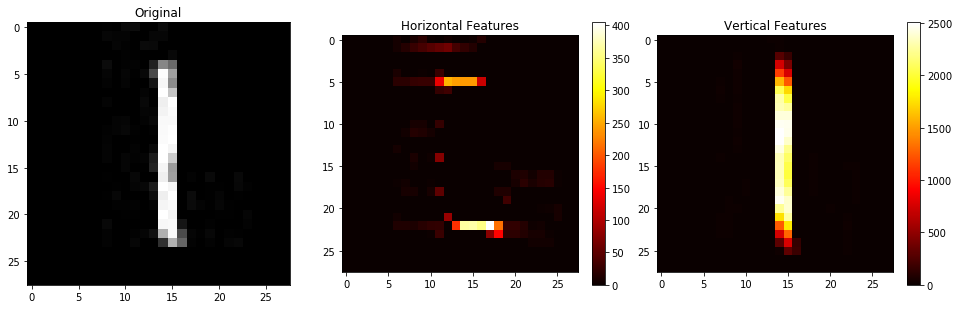

In [9]:
one = imread('one.jpg')

plt.figure(figsize = (16,10))
plt.subplot(131)
plt.title('Original')
plt.imshow(one,'gray')

one_horiz = convolve_2d(one,horiz_kernel)
plt.subplot(132)
plt.title('Horizontal Features')
plt.imshow(one_horiz,'hot')
plt.colorbar(fraction=0.05)

one_vert = convolve_2d(one,vert_kernel)
plt.subplot(133)
plt.title('Vertical Features')
plt.imshow(one_vert,'hot')
plt.colorbar(fraction=0.05)

## Exercise 5: 2D Image Convolution for Feature Detection

a. Create similar plots as the above example for the "1" image for the "4" (``four.jpg``) and "8" (``eight.jpg``) images in the following code cell.

b. Comment on the results and compare what is highlighted for each number.

c. What is the significance of having negative kernel values around the positive "feature highlighting" values? Think about what would happen if the negative values were zeros instead. Try playing around with the kernels or creating your own kernel if you are unsure.


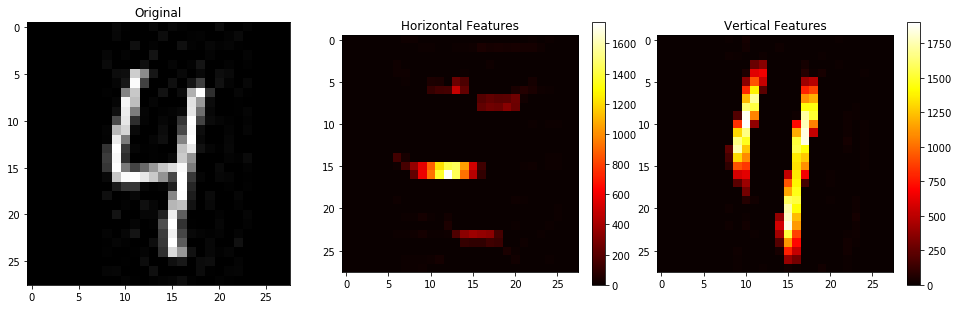

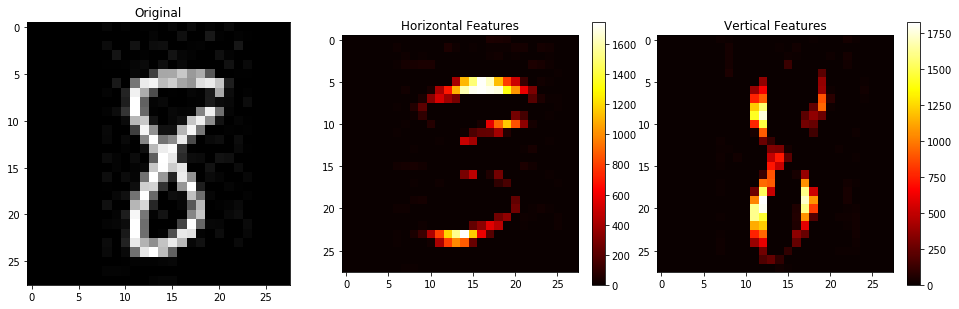

Answer for 5b:

The number four has nice, distinct features highlighted. We get one clear horizontal line with two vertical lines of different length, which is a good description of how to draw a four. The number eight is less clear. The vertical features do highlight each of the four arches in the digit, but the horizontal features highlight what looks a lot like a three. I expect it is difficult to differentiate threes and eights.

Answer for 5c:

The negative kernel values explicitly punish large values in on the outside of each kernel. If we want strong linear features, we should require large values in a well-defined line where the values outside the line must be low. If we used zeros instead of negative numbers, we would highlight large flat regions as containing lines. The negative numbers give us much more discriminative power.

For the final activity, we will explore an example of a non-linear system. First, a bit of background.

There are many different types of noise that can appear in images. One such type is salt-and-pepper noise. This noise occurs when pixels in a camera or an existing image become fully active or inactive. In other words, a normal pixel either takes on its minimum or maximum possible value. The following code cell shows an original image and a version of it that has been corrupted by 20% salt-and-pepper noise (20% of the pixels are affected). In this activity, we will see whether we can use our LSI systems from before to denoise our image.

Text(0.5, 1.0, 'Image with 20% Salt-and-Pepper Noise')

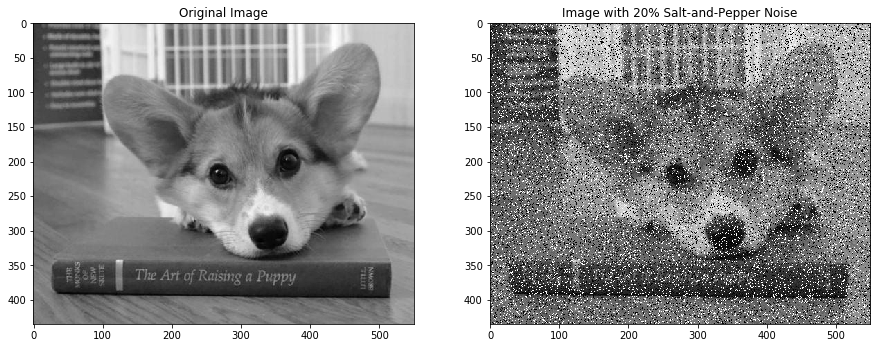

In [11]:
clean_image = imread('clean-image.jpg')
noisy_image = imread('noisy-image.jpg')
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(clean_image,'gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(noisy_image,'gray')
plt.title('Image with 20% Salt-and-Pepper Noise')

## Exercise 6: Non-Linear Systems are Cool Too!

We will attempt to use two different filters: a 5x5 mean filter and a 5x5 median filter. Note that a median filter is a non-linear system! A 5x5 median filter simply takes the median of the 25 pixels surrounding the center pixel in the filter and assigns that value to the center pixel.

a. Explain/prove why the median filter is a non-linear system. You may write your answer with respect to a one-dimensional median filter. 

b. Apply a 5x5 mean filter to the noisy image and plot the result. You can do this two different ways. You can apply a length-5 mean filter along the rows and columns in any order or use our $\textrm{convolve_2d()}$ function from before with an appropriate filter you create.

c. Apply a 5x5 median filter to the noisy image and plot the result. Use $\textrm{signal.medfilt()}$ to perform the filtering. Look up the scipy documentation for notes on this function's usage.

d. Comment on the differences. Which filter seems to work better? Why do you think so?

Text(0.5, 1.0, 'Median-filtered Result')

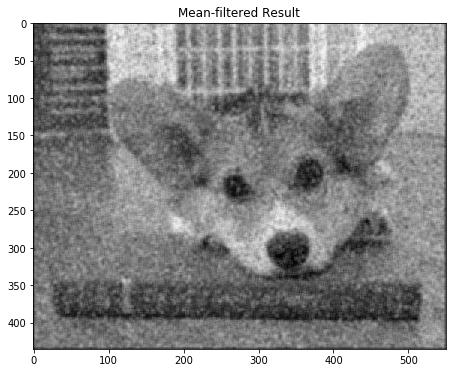

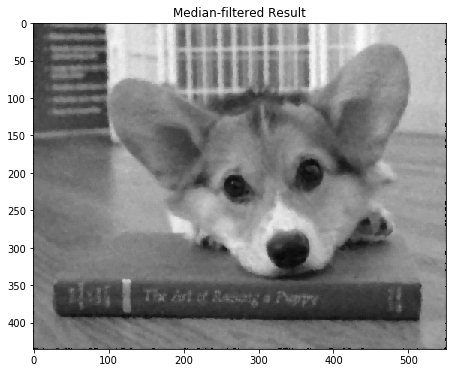

Answer for 6.a here:

Let $x_1 = [1, 5, 3]$ and $x_2 = [6, 3, 7]$. We would then have $median(x_1) = 3$ and $median(x_2) = 6$. Finally, $x_1+x_2=[7,8,10]$ has $median(x_1+x_2) = 8 \neq median(x_1) + median(x_2)$, thus the median operator is non-linear.

Answer for 6.d here:

The median filter works much better since it attempts to replace the noisy pixels with a nearby typical/clean pixel. The mean filter, on the other hand, spreads out the noise from the affected pixels and ends up significantly "smudging" the image.

## Submission Instructions

Make sure to place all image and data files along with your .ipynb lab report (this file) in one folder, zip the folder, and submit it to Compass under the Lab 2 assignment. Please name the zip file ``<netid>_Lab2``.